In [1]:
import sys
import json
import warnings

import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../..')
from matplotlib.colors import LinearSegmentedColormap
from utils import UnimapResult, set_plot_theme, generate_positions

set_plot_theme()
warnings.filterwarnings('ignore')

In [2]:
s_data = sc.read_h5ad('../../data/pbmc40/pbmc40.h5ad')
t_data = sc.read_h5ad('../../data/pbmc40/pbmc10.h5ad')
s_data.obs['domain'] = 'source'
t_data.obs['domain'] = 'target'
raw_data = sc.concat([s_data, t_data], join='outer')
sc.tl.pca(raw_data, svd_solver='arpack') 
sc.pp.neighbors(raw_data, n_neighbors=10, n_pcs=40)
sc.tl.umap(raw_data)

result = UnimapResult('pbmc40', f'unimap/2023', root_dir='../../results', detailed=False)

color_dict = json.load(open('../../color_dict.json'))
batch_c = color_dict["pbmc40_batch"]

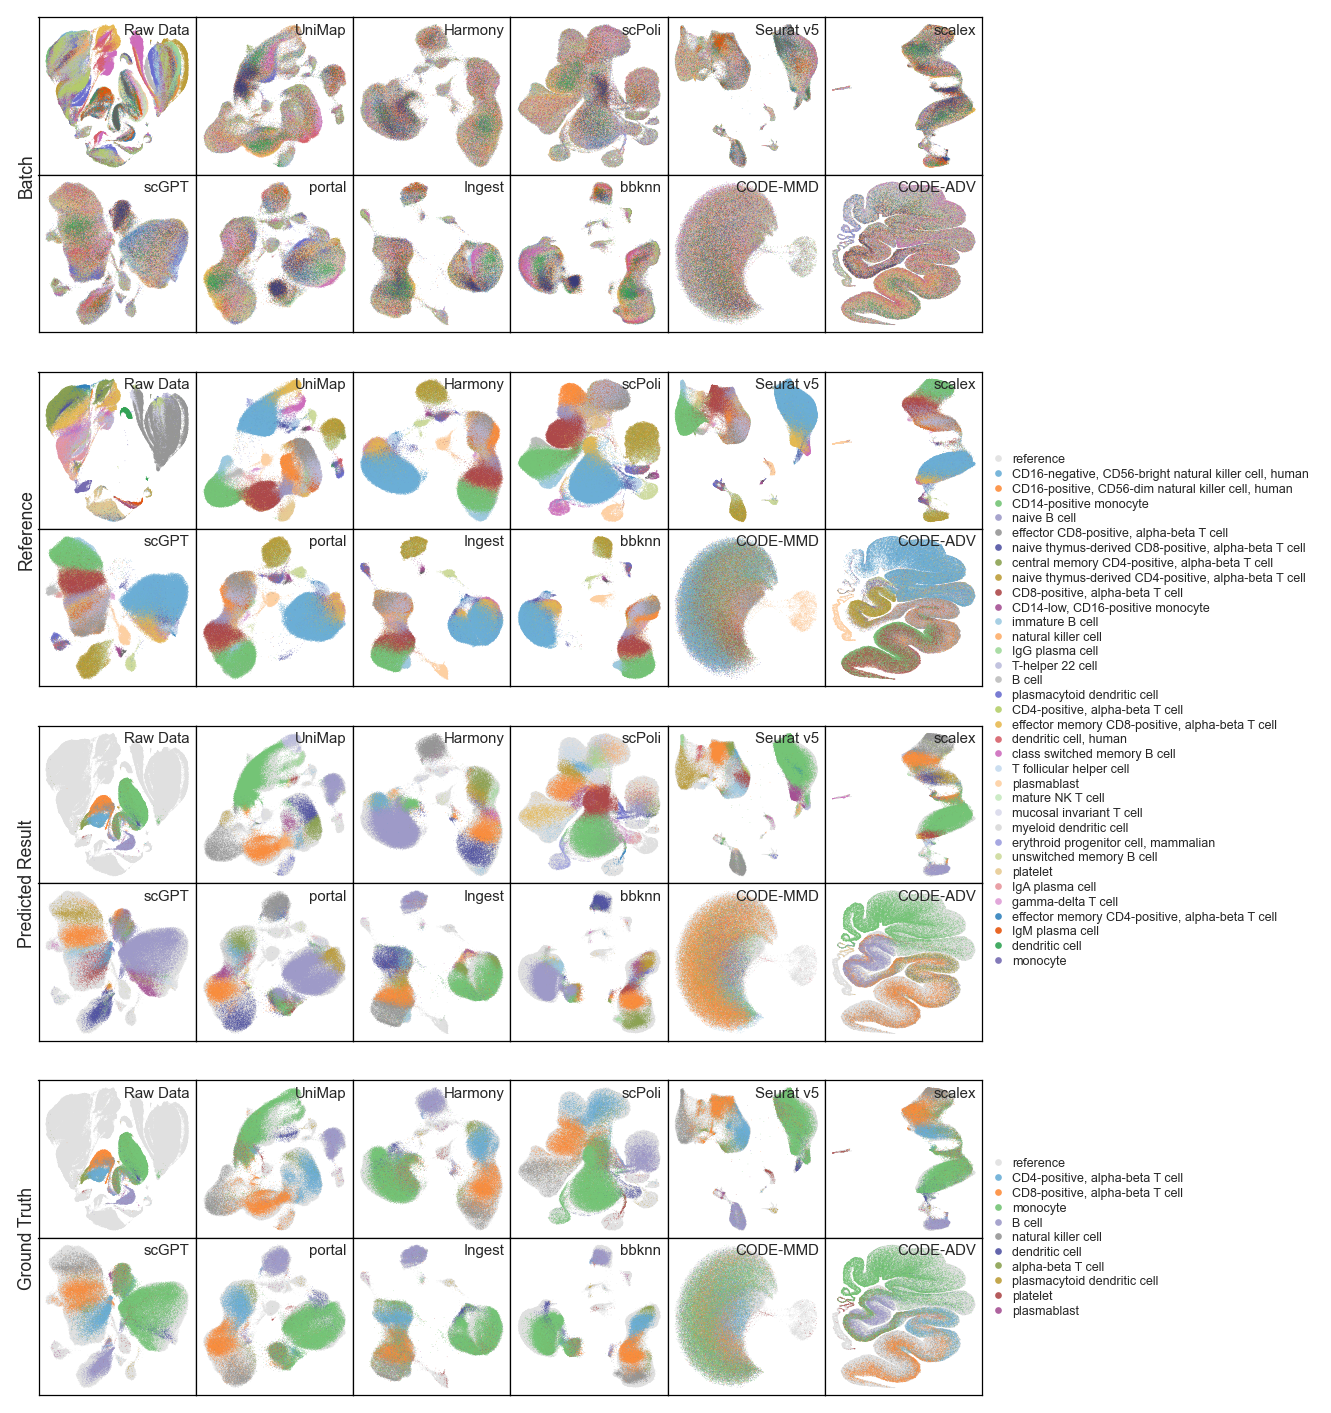

In [3]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

models      = ['raw_data', 'unimap', 'harmony', 'scpoli', 'seurat',    'scalex', 'scgpt', 'portal', 'ingest', 'bbknn', 'code_mmd', 'code_adv']  # 
models_name = ['Raw Data', 'UniMap', 'Harmony', 'scPoli', 'Seurat v5', 'scalex', 'scGPT', 'portal', 'Ingest', 'bbknn', 'CODE-MMD', 'CODE-ADV']  #  

position1 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.02, b=0.8)
position2 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.02, b=0.6)
position3 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.02, b=0.4)
position4 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.02, b=0.2)

for idx, model in enumerate(models):
    model_name = models_name[idx]
    if model == 'raw_data':
        umap1 = raw_data.obsm['X_umap'][:, 0]
        umap2 = raw_data.obsm['X_umap'][:, 1]
        s_umap1 = umap1[raw_data.obs['domain'] == 'source']
        s_umap2 = umap2[raw_data.obs['domain'] == 'source']

        batch_labels = list(raw_data.obs['batch'])
        ref = raw_data[raw_data.obs['domain'] == 'source'].obs.celltype
        ref_labels = ['reference'] * sum(raw_data.obs['domain']  ==  'source')
        ct_labels = ref_labels + list(raw_data[raw_data.obs.domain == 'target'].obs.celltype)
        pd_ct_labels = ct_labels
    else:
        result = UnimapResult('pbmc40', f'{model}/2023', root_dir='../../results', detailed=False)
        umap1  = result.st_umap_result['umap1']
        umap2  = result.st_umap_result['umap2']
        s_umap1 = result.s_umap_result['umap1']
        s_umap2 = result.s_umap_result['umap2']

        batch_labels = list(result.st_result.batch)
        ref = result.s_result.celltype
        ref_labels = ['reference'] * len(result.s_result['domain'])
        ct_labels = ref_labels + list(result.t_result.celltype)
        pd_ct_labels = ref_labels + list(result.t_result.pred_celltype)
    

    ax1 = fig.add_axes(position1[idx])
    ax2 = fig.add_axes(position2[idx])
    ax3 = fig.add_axes(position3[idx])
    ax4 = fig.add_axes(position4[idx])
    
    s = 0.05
    p1 = sns.scatterplot(x=umap1,   y=umap2,   alpha=0.9, s=s, hue=batch_labels, edgecolor='none', palette=result.color60,               ax=ax1, rasterized=True)
    p2 = sns.scatterplot(x=s_umap1, y=s_umap2, alpha=0.9, s=s, hue=ref,          edgecolor='none', palette=result.color60,               ax=ax2, rasterized=True)
    p3 = sns.scatterplot(x=umap1,   y=umap2,   alpha=0.9, s=s, hue=pd_ct_labels, edgecolor='none', palette=['#E0E0E0'] + result.color60, ax=ax3, rasterized=True)
    p4 = sns.scatterplot(x=umap1,   y=umap2,   alpha=0.9, s=s, hue=ct_labels,    edgecolor='none', palette=['#E0E0E0'] + result.color60, ax=ax4, rasterized=True)

    p1 = result.remove_ticks(p1, remove_legend=True)
    p2 = result.remove_ticks(p2, remove_legend=True)
    p3 = result.remove_ticks(p3, remove_legend=True)
    p4 = result.remove_ticks(p4, remove_legend=True)

    p1yl = p1.set_ylabel('' if idx != 0 else 'Batch',            fontsize=7, labelpad=1)
    p2yl = p2.set_ylabel('' if idx != 0 else 'Reference',        fontsize=7, labelpad=1)
    p3yl = p3.set_ylabel('' if idx != 0 else 'Predicted Result', fontsize=7, labelpad=1)
    p4yl = p4.set_ylabel('' if idx != 0 else 'Ground Truth',     fontsize=7, labelpad=1)
    p1yl.set_position((0, 0.0))
    p2yl.set_position((0, 0.0))
    p3yl.set_position((0, 0.0))
    p4yl.set_position((0, 0.0))
    p1.text(0.96, (0.92), model_name, ha='right', va='center', transform=p1.transAxes, fontsize=6)
    p2.text(0.96, (0.92), model_name, ha='right', va='center', transform=p2.transAxes, fontsize=6)
    p3.text(0.96, (0.92), model_name, ha='right', va='center', transform=p3.transAxes, fontsize=6)
    p4.text(0.96, (0.92), model_name, ha='right', va='center', transform=p4.transAxes, fontsize=6)
    if idx == len(models) - 1:
        # p1.legend(loc='center left', bbox_to_anchor=(1, 1.3), frameon=False, markerscale=12, fontsize=5, labelspacing=0.4)
        # p2.legend(loc='center left', bbox_to_anchor=(1, 1), frameon=False, markerscale=12, fontsize=5, labelspacing=0.4)
        p3.legend(loc='center left', bbox_to_anchor=(0.95, 2.1), frameon=False, markerscale=12, fontsize=5, labelspacing=0.2, handletextpad=0.1)
        p4.legend(loc='center left', bbox_to_anchor=(0.95, 1.0), frameon=False, markerscale=12, fontsize=5, labelspacing=0.2, handletextpad=0.1)

# plt.tight_layout()
plt.show()

In [36]:
# fig.savefig('../figs/supplementary fig3.pdf', dpi=720)
# fig.savefig('../sup_figs/sup3.png', dpi=540)

### sHANNONS score

In [37]:
# raw_t_data = sc.read_h5ad('../../data/pbmc40/pbmc10.h5ad')
# unimap_result = UnimapResult('pbmc40', 'unimap/2023', root_dir='../../results')
# models = ['unimap', 'harmony', 'scpoli', 'seurat', 'scalex', 'scgpt'] + ['portal', 'ingest', 'bbknn', 'code_mmd', 'code_adv']

# eval_results = pd.DataFrame()
# metrics = pd.DataFrame()
# for model in models:
#     result = UnimapResult('pbmc40', f'{model}/2023', root_dir='../../results', detailed=False)
#     unimap_ad = sc.AnnData(X=result.t_z_result.values, obs=result.t_result)
#     unimap_ad.obsm['X_emb'] = result.t_z_result.values
#     for col in unimap_ad.obs.columns:
#         unimap_ad.obs[col] = unimap_ad.obs[col].astype('category')
#     metrics.loc[result.model, 'average_shannons_score'] = shannons_score(unimap_ad, pred_label_key='pred_celltype', label_key='celltype', mode='average')
# metrics['rank'] = metrics['average_shannons_score'].rank(ascending=False)
# metrics['Models'] = models


# metrics['rank'] = metrics['average_shannons_score'].rank(ascending=False)
# metrics['Models'] = models
# metrics.to_csv('results/shannons_score.csv', index=False)

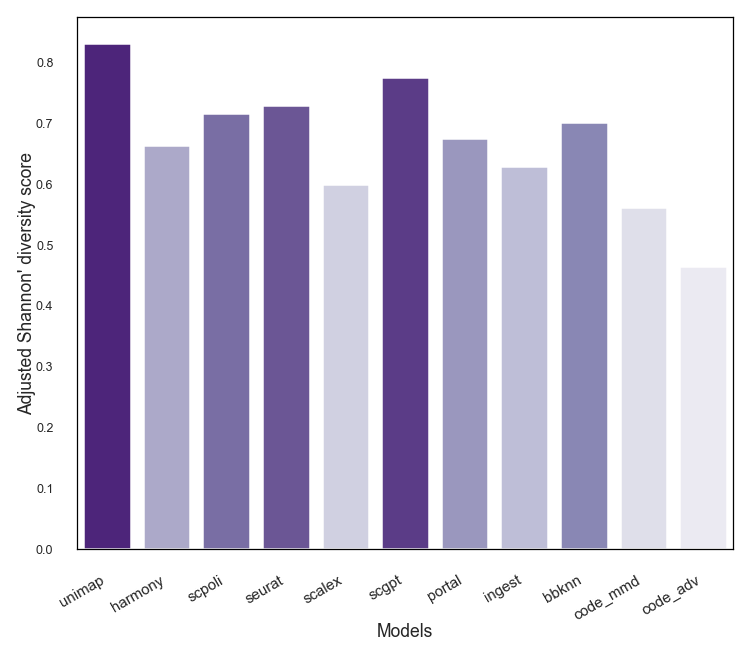

In [4]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

metrics = pd.read_csv("results/shannons_score.csv", index_col=0)
cmap3_list = [ '#4c1788', '#a7a4ce', '#7465ad', '#674ba0', '#cdcde4', '#593093', '#9591c4', '#babadb', '#827fbb', '#ddddec', '#eae9f3']

postion = [0.25, 0.6, 0.5, 0.3]
p = sns.barplot(x='Models', y='average_shannons_score', data=metrics, palette=cmap3_list, hue='Models', ax=fig.add_axes(postion))
# plt.title('Average Shannon\'s Score for Different Models')
p.set_xlabel('Models', fontsize=7,labelpad=0)
p.set_ylabel('Adjusted Shannon\' diversity score', fontsize=7, labelpad=0)
p.set_xticklabels(labels=metrics['Models'], rotation=30, ha='right', fontsize=6)
p = p.set_yticklabels(labels=p.get_yticks().round(2), fontsize=5)
# fig.savefig('supplementary fig4.pdf', dpi=360, bbox_inches='tight')

In [39]:
# fig.savefig('../figs/supplementary fig4.pdf', dpi=720)
# fig.savefig('../sup_figs/sup4.png', dpi=720)

In [5]:
color_dict = json.load(open('../../color_dict.json'))
ct_order = color_dict["pbmc40_ct_query_order"]
pd_ct_order = color_dict["pbmc40_ct_ref_order"]

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f4f3f8', '#827fbb'] )

positions = [
    [0.3, 0.87, 0.5, 0.10],
    [0.3, 0.74, 0.5, 0.10],
    [0.3, 0.61, 0.5, 0.10],
    [0.3, 0.48, 0.5, 0.10],
    [0.3, 0.35, 0.5, 0.10],
    [0.3, 0.22, 0.5, 0.10],
             ]


models1 = ['unimap', 'harmony', 'scpoli', 'seurat', 'scalex', 'scgpt']
models2 = ['portal', 'ingest', 'bbknn', 'code_mmd', 'code_adv']

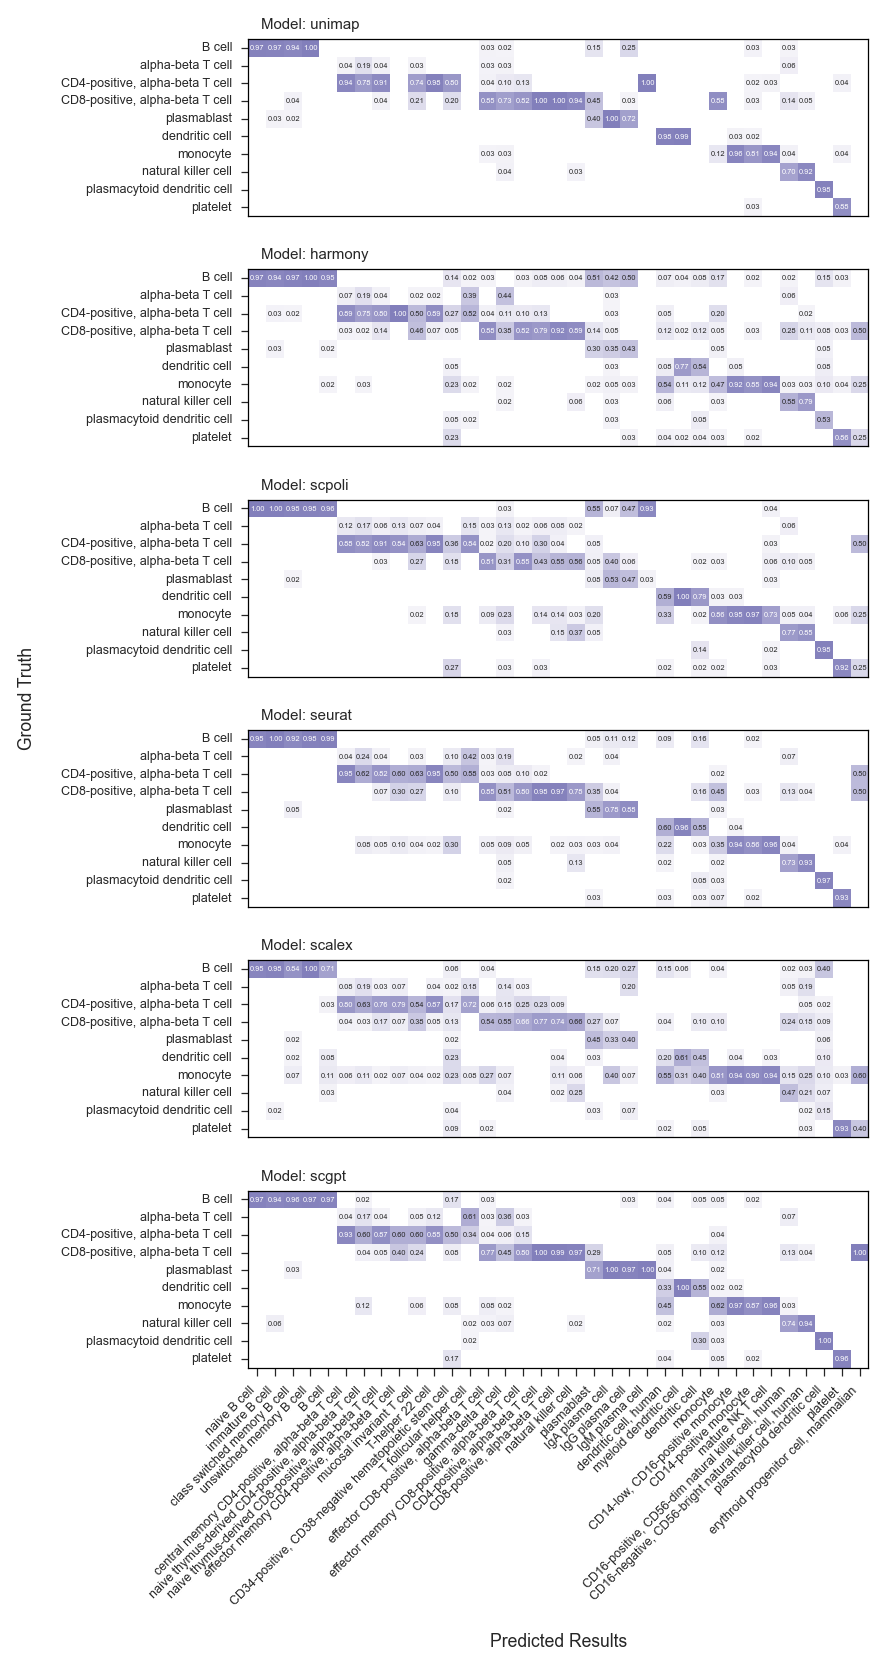

In [6]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove() 

for idx, model in enumerate(models1):
    result = UnimapResult('pbmc40', f'{model}/2023', root_dir='../../results', detailed=False)

    cm = result.get_cm(percentage_direction=1, ct_labels=ct_order, pd_ct_labels=pd_ct_order)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), yticklabels=ct_order, xticklabels=pd_ct_order)
    result.remove_spines(ax, sp_v=True, remove_legend=False)
    ax.text(0.02, 1.08, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.set_yticklabels(ct_order, rotation=0, fontsize=5)
    ax.tick_params(bottom=False, top=False, left=True, right=False, length=3, width=0.5)
    if idx == 5:  # True
        ax.set_xticklabels(pd_ct_order, rotation=45, ha='right', fontsize=5)
        ax.tick_params(bottom=True, top=False, left=True, right=False, length=3, width=0.5)
    else:
        ax.set_xticklabels([])

    if idx == 2:
        ylabel = ax.set_ylabel('Ground Truth', fontsize=7, labelpad=10)
        ylabel.set_position((0, -0.12))
    if idx == 5:
        ax.set_xlabel('Predicted Results', fontsize=7, labelpad=10)

In [42]:
# fig.savefig('../figs/supplementary fig5a.pdf', dpi=720)
# fig.savefig('../sup_figs/sup5a.png', dpi=720)

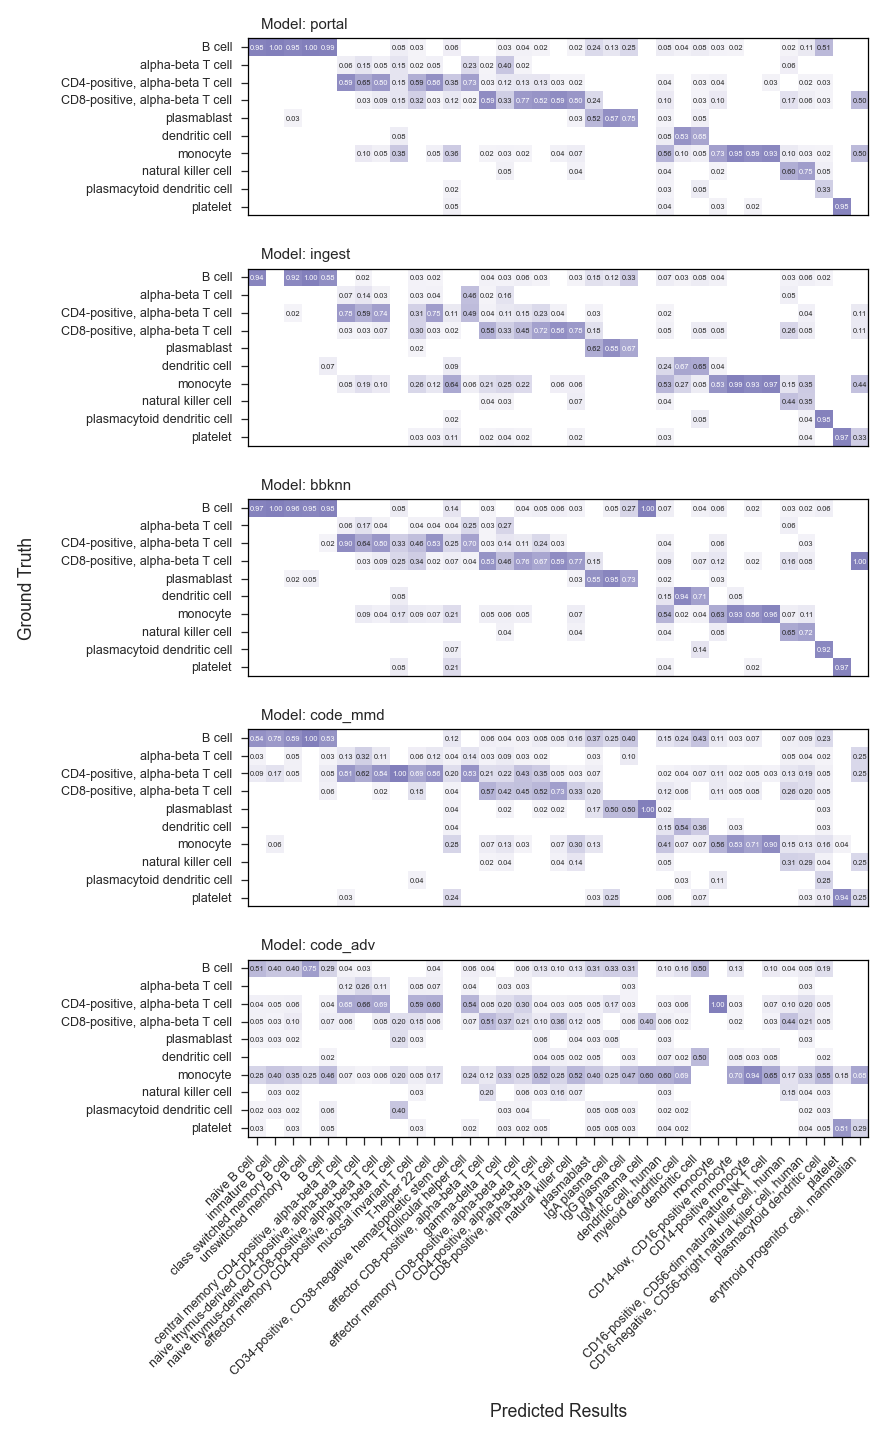

In [7]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove() 

for idx, model in enumerate(models2):
    result = UnimapResult('pbmc40', f'{model}/2023', root_dir='../../results', detailed=False)

    cm = result.get_cm(percentage_direction=1, ct_labels=ct_order, pd_ct_labels=pd_ct_order)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), yticklabels=ct_order, xticklabels=pd_ct_order)
    result.remove_spines(ax, sp_v=True, remove_legend=False)
    ax.text(0.02, 1.08, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.set_yticklabels(ct_order, rotation=0, fontsize=5)
    ax.tick_params(bottom=False, top=False, left=True, right=False, length=3, width=0.5)
    if idx == 4:  # True
        ax.set_xticklabels(pd_ct_order, rotation=45, ha='right', fontsize=5)
        ax.tick_params(bottom=True, top=False, left=True, right=False, length=3, width=0.5)
    else:
        ax.set_xticklabels([])

    if idx == 2:
        ylabel = ax.set_ylabel('Ground Truth', fontsize=7, labelpad=10)
    if idx == 4:
        ax.set_xlabel('Predicted Results', fontsize=7, labelpad=10)

In [44]:
# fig.savefig('../figs/supplementary fig5b.pdf', dpi=720)
# fig.savefig('../sup_figs/sup5b.png', dpi=720)